# BATF Proof of Concept

This notebook is for creating a small dataset consisting of just POL2 guide cells and control cells (no guides), then performing some unsupervised and supervised training of scVI.

### Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.models.cvae as cv

### Create a small metadata file

This metadata will contain all BATF, IRF4, JUNB KO cells as well as about 800 cells with no guides.

In [6]:
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1_default.norm.meta.txt'
abridged_metadata_filename = data_path + 'simple_metadata.txt'
metadata = pd.read_csv(metadata_filename, sep='\t')

In [7]:
ko_metadata = metadata[
    (metadata['guide_cov'].str.contains('BATF')) | 
    (metadata['guide_cov'].str.contains('IRF4')) |
    (metadata['guide_cov'].str.contains('JUNB'))]
ng_metadata = metadata.query('guide_cov == "0"').sample(800)

In [8]:
sample_metadata = pd.concat([ko_metadata, ng_metadata])

In [9]:
sample_metadata.to_csv(abridged_metadata_filename, sep='\t')

### Create a dataset for training

In [11]:
h5_filename = '/Users/mincheolkim/Documents/raw_gene_bc_matrices_h5.h5'

In [61]:
imp.reload(cs)
# Load the dataset for training
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=abridged_metadata_filename,
    new_n_genes=2000,
    subset_genes=['IL10', 'RORC', 'SIRT1'],
    batch='wells',
    use_labels='gene',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 3532
Number of cells kept after removing all zero cells: 3532
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 2000 genes


### Train an unsupervised model

In [13]:
n_epochs=200
lr=1e-4
use_batches=True
use_cuda=False

In [14]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
infer = VariationalInference(
    vae, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=False,
    frequency=1)
infer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [14:26<00:00,  4.33s/it]


### Train a supervised model

In [62]:
imp.reload(cv)
imp.reload(svi)

<module 'scvi_extensions.inference.supervised_variational_inference' from '/Users/mincheolkim/Github/scVI-extensions/scvi_extensions/inference/supervised_variational_inference.py'>

In [63]:
cvae = cv.CVAE(gene_dataset.nb_genes, n_labels=gene_dataset.n_labels, n_batch=gene_dataset.n_batches * use_batches)
supervised_infer = svi.SupervisedVariationalInference(
    cvae, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=False,
    frequency=1)
supervised_infer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [15:28<00:00,  4.64s/it]


### Differential Expression

In [49]:
imp.reload(cs)
# Load the dataset for training
de_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=abridged_metadata_filename,
    new_n_genes=2000,
    subset_genes=['IL10', 'RORC', 'SIRT1'],
    batch='wells',
    use_labels='gene',
    testing_labels='gene',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 3532
Number of cells kept after removing all zero cells: 3532
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 2000 genes


In [55]:
de_results = mn.differential_expression(vae, de_dataset, [0, 1, 2, 3], 100)

Sampling for differential expression...
Done sampling for differential expression...


In [98]:
de_results[1][0][3].head(5)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
489,ALOX5AP,489,0.3555,-0.594950,0.594950,0.0,-1.0
1417,EMC7,1417,0.3591,-0.579273,0.579273,0.0,-1.0
1092,CDC42SE1,1092,0.3598,-0.576232,0.576232,0.0,-1.0
1392,CNIH4,1392,0.3607,-0.572327,0.572327,0.0,-1.0
1168,DYNLT1,1168,0.3637,-0.559341,0.559341,0.0,-1.0


In [64]:
supervised_de_results = mn.differential_expression(cvae, de_dataset, [0, 1, 2, 3], 100)

Sampling for differential expression...
Done sampling for differential expression...


In [76]:
de_dataset.cell_types

array(['BATF', 'IRF4', 'JUNB', 'NO_GUIDE'], dtype='<U8')

In [122]:
print(supervised_de_results[1][2][3].query('gene == "SIRT1"')['bayes_factor_mag'])
print(de_results[1][2][3].query('gene == "SIRT1"')['bayes_factor_mag'])

2    0.270029
Name: bayes_factor_mag, dtype: float64
2    0.247252
Name: bayes_factor_mag, dtype: float64


/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


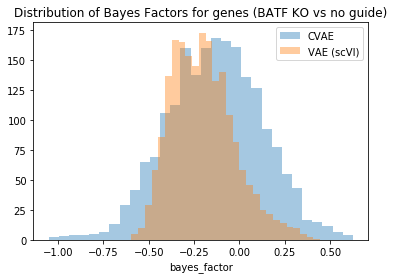

In [128]:
sns.distplot(supervised_de_results[1][0][3]['bayes_factor'], kde=False)
sns.distplot(de_results[1][0][3]['bayes_factor'], kde=False)
plt.title('Distribution of Bayes Factors for genes (BATF KO vs no guide)')
plt.legend(['CVAE', 'VAE (scVI)'])

In [134]:
temp = pd.DataFrame(
    [
        ('IL10', 'CVAE', 0.203904),
        ('IL10', 'VAE (scVI)', 0.164772),
        ('RORC', 'CVAE', 0.37431),
        ('RORC', 'VAE (scVI)', 0.207137),
        ('SIRT1', 'CVAE', 0.270029),
        ('SIRT1', 'VAE (scVI)', 0.247252)
], columns=['gene', 'model', 'Bayes factor magnitude'])

In [173]:
sns.set_palette("muted")

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


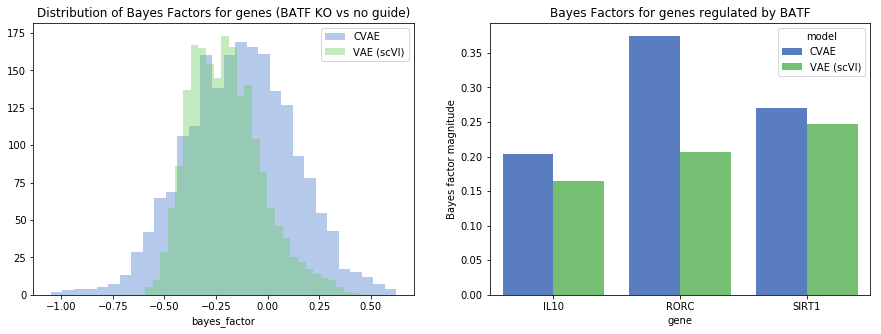

In [174]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

sns.distplot(supervised_de_results[1][0][3]['bayes_factor'], kde=False)
sns.distplot(de_results[1][0][3]['bayes_factor'], kde=False)
plt.title('Distribution of Bayes Factors for genes (BATF KO vs no guide)')
plt.legend(['CVAE', 'VAE (scVI)'])
plt.subplot(1, 2, 2)
sns.barplot(x='gene', y='Bayes factor magnitude', hue='model', data=temp)
plt.title('Bayes Factors for genes regulated by BATF')
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/batf_poc.png')

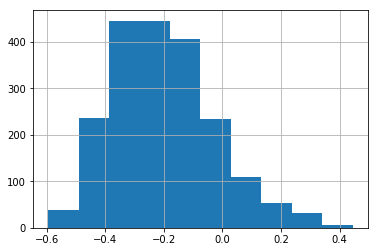

In [108]:
de_results[1][0][3]['bayes_factor'].hist()

In [104]:
de_results[1][2][3].query('gene == "IL10"')

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
0,IL10,0,0.4589,-0.164772,0.164772,2.011485e-32,-1.0


## Compare Bayes Factors between supervised and unsupervised training

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


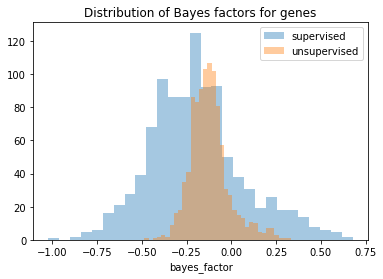

In [58]:
sns.distplot(supervised_de_results[0][1]['bayes_factor'], kde=False)
sns.distplot(de_results[0][1]['bayes_factor'], kde=False)
plt.title('Distribution of Bayes factors for genes')
plt.legend(['supervised', 'unsupervised'])